# Sensor Model - CUDA accelerated


- cast
- compute sliding windows
- and mixture components $\tilde{y}$
- compute likelihood

In [31]:
display(HTML("<style>.rendered_html.text_cell_render {max-width:500px; }</style>"));
push!(LOAD_PATH, "../src");

HTML{String}("<style>.rendered_html.text_cell_render {max-width:500px; }</style>")

In [2]:
#nbx --fname="src/sensor_b.jl"
using CUDA

## Raycaster

In [3]:
#nbx
include("../src/cuda_raycaster_point_cloud_b.jl")
@doc cast_cu!

```
cast_cu!(z_, y_, p_; fov=π, cell_rad=0.005, blockdims=(16,16))
```

Collects `n` sensor scans in an obs array `z` of shape `(n, a)` from `n` poses given by an array `p` `(n,3)` and `(n,)` and a point cloud `y` of shape `(m,2)`.


In [4]:
#nbx
"""
    z_ = cast_cu(ps_::CuArray, ys_::CuArray; fov=2π, zmax::Float64=Inf, cell_rad=0.01)

Point cloud raycasting ...
"""
function cast_cu(ps_::CuArray, ys_::CuArray; fov=2π, zmax::Float64=Inf, cell_rad=0.01)
    z_ = zmax*CUDA.ones(size(ps_, 1), 361)
    cast_cu!(z_, ys_, ps_; fov=fov, cell_rad=cell_rad)
    return z_
end

cast_cu

In [5]:
include("src/csail_data.jl")

Loading `../data/mit-csail.json` ...

	_zs 	Vector{Vector{Float64}}
	_as 	Vector{Float64}
	_zmax 	Float64
	_ys 	Vector{Vector{Vector{Float64}}}
	_num_a 	Int64
	_xs 	Vector{Vector{Float64}}
	_hds 	Vector{Float64}
	_ps 	Vector{Pose}
	_dxs 	Vector{Vector{Float64}}
	_dhds 	Vector{Float64}
	_us 	Vector{Control}
	_T 	Int64


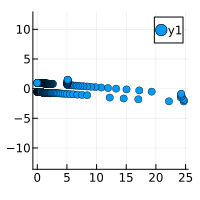

In [6]:
t = 1050
# ----------------------
plot(size=(200,200), aspect_ratio=:equal)
scatter!(_ys[t])

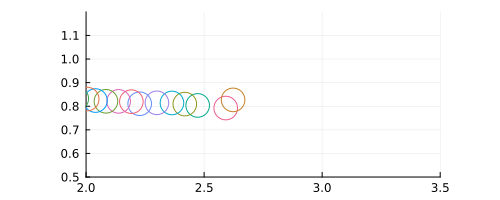

In [7]:
r = 0.05
mypl = plot(size=(500,200), aspect_ratio=:equal, xlim=(2.0,3.5),ylim=(0.5,1.2), legend=nothing)
for y in _ys[t][1:end]
    plot!([y + r.*[cos(th);sin(th)] for th in range(0,2π,40)])
end
mypl

(1, 3)(361, 2)
(1, 3)(361, 2)(1, 361)


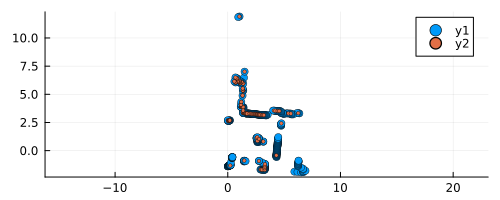

In [12]:
ps  = [Pose(0,5,0)]
ps_ = CuArray(stack(Vector.(ps)))

ys_ = CuArray(stack(_ys[t]))
println(size(ps_),size(ys_))
z_  = cast_cu(ps_, ys_, fov=π, cell_rad=0.01)
z   = Array(z_)

println(size(ps_),size(ys_), size(z_))
i=1

ys  = polar_inv(z[i,:], _as)
# ----------------------
plot(size=(500,200), aspect_ratio=:equal)
scatter!(_ys[t])
scatter!(ys.*ps[i], markersize=2)


## Sliding window

 - $k$ - number of poses
 - $n$ - number of observations per scan
 - $m$ - number of mixture components

In [9]:
#nbx
"""
    slw_kernel!(x, w::Int, y)

CUDA kernel to compute sliding windows...
Takes CuArrays of shape `(k,n)` and `(k,n,m=2w+1)` 
and fills the latter with ...
"""
function slw_kernel!(x, w::Int, y)
    
    m = 2*w + 1
    
    # Make sure the arrays are 
    # of the right shape
    @assert ndims(x)  == 2
    @assert ndims(y)  == ndims(x) + 1
    @assert size(x,1) == size(y,1)
    @assert size(x,2) == size(y,2)
    @assert size(y,3) == m
    
    # Thread id's
    ix = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    iy = (blockIdx().y - 1) * blockDim().y + threadIdx().y
    iz = (blockIdx().z - 1) * blockDim().z + threadIdx().z
    sx = gridDim().x * blockDim().x
    sy = gridDim().y * blockDim().y
    sz = gridDim().z * blockDim().z
        
    for j_pose = ix:sx:size(y,1), j_obs = iy:sy:size(y,2), j_mix = iz:sz:size(y,3)
        # Transform `1:m` to `-w:w`
        offset = j_mix-1-w
        
        # Wrap around, e.g. map `n+1` to `1`
        # Note that we have `size(x,2) == size(y,2)`
        j_mix_adj = mod(j_obs + offset - 1 , size(x,2)) + 1
        
        # Fill y's
        @inbounds y[j_pose, j_obs, j_mix] = x[j_pose, j_mix_adj]
    end
    return
end

"""
```julia
    y = slw_cu!(x::CuArray, w::Int; blockdims=(8,8,4))
```
CUDA-accelerated function computing sliding windows. 
Takes a CuArray of shape `(k,n)` and returns a CuArray
of shape `(k,n,m)`, where `m = 2w+1`....
"""
function slw_cu!(x::CuArray, w::Int; blockdims=(8,8,4))
    
    k = size(x, 1)
    n = size(x, 2)
    m = 2*w+1
    
    y = CUDA.ones(k,n,m)
    
    griddims = cuda_grid((k,n,m), blockdims)
    CUDA.@sync begin
        @cuda threads=blockdims blocks=griddims slw_kernel!(x, w, y)
    end
    
    return y
end;

## Mixture components

In [16]:
#nbx
polar_inv_cu(z::CuArray, a::CuArray) = cat(z.*cos.(a), z.*sin.(a), dims=ndims(a)+1);


"""
    ys_tilde_ = get_ys_tilde_cu(zs_::CuArray, w::Int)    

Takes depth measurements and returns 
the point clouds for the gaussian mixtures ...
Returns array of shape `(k, n, m, 2)` ...
"""
function get_ys_tilde_cu(zs_::CuArray, as_::CuArray, w::Int)   

    zs_tilde_ = slw_cu!(zs_, w; blockdims=(8,8,4))
    as_tilde_ = slw_cu!(reshape(as_,1,:), w; blockdims=(8,8,4))
    ys_tilde_ = polar_inv_cu(zs_tilde_, as_tilde_)
    
    return ys_tilde_
end;

In [17]:
unstack(x::Matrix) = [x[i,:] for i=1:size(x,1)]

unstack (generic function with 1 method)

(1, 361, 41, 2)


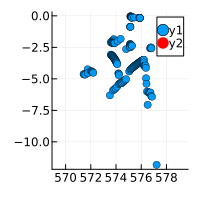

In [27]:
a_ = CuArray(_as)
ys_tilde_ = get_ys_tilde_cu(z_, a_, w)    
ys_tilde  = Array{Float64}(ys_tilde_)

println(size(ys_tilde_))

# ----------------------
plot(size=(200,200), aspect_ratio=:equal)
scatter!(ys.*_ps[t])
scatter!(unstack(ys_tilde[t,i,:,:]).*_ps[t], c=:red, markerstrokewidth=0)


## Likelihoods

In [19]:
#nbx
function logsumexp_cu(x, dim)
    c = maximum(x)
    return c .+ log.(sum(exp.(x .- c), dims=dim))
end

logsumexp_cu (generic function with 1 method)

In [20]:
#nbx
"""
    log_p = gaussian_logpdf(x, mu, sig)

Benchmarks in `33 - CUDA Accelerated Gen Distributions` ...
"""
function gaussian_logpdf(x, mu, sig)
    d = (x .- mu).^2 ./ sig.^2
    log_p = - log.(sqrt.(sig * 2 * π)) .- 1/2 * d
    return log_p
end;

In [22]:
#nbx
"""
    log_p = sensor_smc_logpdf_cu(x::CuArray, ys_tilde::CuArray, sig, outlier)

Evaluates the logpdf of an observation `x` (shape: `(n,2)`)
with respect to a number of different gaussian mixtures (e.g. from family 
of different poses) stacked along the first dim of `ys_tilde` (k,n,m,2) ...
"""
function sensor_smc_logpdf_cu(x, ys_tilde, sig, outlier, outlier_vol=1.0)

    n = size(ys_tilde,2)
    m = size(ys_tilde,3)
    
    xs = reshape(x, 1, n, 1, 2)
    
    # Line by line...
    # 1. Compute 1D Gaussians - (n,m,2)
    # 2. Convert to 2D gausians - (n,m)
    # 3. Convert to mixture of m 2D gausians (GM) - (n,)
    # 4. Convert to mixture of `GM` and `anywhere` (D) - (n,)
    # 5. Convert to Product of D's - ()
    log_p = gaussian_logpdf(xs, ys_tilde, sig)
    log_p = sum(log_p, dims=4)[:,:,:,1] 
    log_p = logsumexp_cu(log_p .- log(m), 3)[:,:,1] 
    log_p_or_any = log.((1-outlier)*exp.(log_p) .+ outlier/outlier_vol)
    log_p = sum(log_p_or_any ,dims=2)[:,1]
    
    return log_p
end;

In [24]:
#nbx
function sensor_logpdf_cu(x::CuArray, y_tilde::CuArray, sig, outlier, outlier_vol=1.0)
    n = size(y_tilde,1)
    m = size(y_tilde,2)
    
    @assert size(x,1) == size(y_tilde,1)
    
    x = reshape(x, n, 1, 2)
    
    # Compute 1D Gaussians - (n,m,2)
    # Convert to 2D gausians - (n,m)
    # Convert to mixture of m 2D gausians (GM) - (n,)
    # Convert to mixture of `GM` and `anywhere` (D) - (n,)
    # Convert to Product of D's - ()
    log_p = gaussian_logpdf(x, y_tilde, sig)
    log_p = sum(log_p, dims=3)[:,:,1] 
    log_p = logsumexp_cu(log_p .- log(m), 2)[:,1] 
    log_p_or_any_ = log.((1-outlier)*exp.(log_p) .+ outlier/outlier_vol)
    log_p = sum(log_p_or_any_)
    return log_p
end

sensor_logpdf_cu (generic function with 2 methods)

In [32]:
#nbx
push!(LOAD_PATH, ENV["probcomp"]*"/Gen-Distribution-Zoo/src");
using GenDistributionZoo: diagnormal

In [33]:
#nbx
using Gen
struct SensorDistribution_CUDA <: Distribution{Vector{Vector{Float64}}} 
end

const sensordist_cu = SensorDistribution_CUDA()

function Gen.logpdf(::SensorDistribution_CUDA, x, y_tilde_::CuArray, sig, outlier, outlier_vol=1.0)
    
    n,m, = size(y_tilde)
    
    x_        = CuArray(stack(x))
    ys_tilde_ = reshape(y_tilde, 1, n, m, 2) 
    
    return sensor_smc_logpdf_cu(x_, ys_tilde_, sig, outlier, outlier_vol)
end

function Gen.random(::SensorDistribution_CUDA, y_tilde_::CuArray, sig, outlier, outlier_vol=1.0)
    n = size(y_tilde_,1)
    m = size(y_tilde_,2)
    
    # Sample an observation point cloud `x`
    x = Vector{Float64}[]
    for i=1:n
        if bernoulli(outlier)
            # Todo: Change that to a uniform distribution, e.g. over a  
            #       circular area with radius `zmax`.
            x_i = [Inf;Inf]
        else
            j   = rand(1:m)
            y   = Array(y_tilde_[i,j,:])
            x_i = diagnormal(y, [sig;sig])

        end
        push!(x, x_i)
    end
    
    return x
end

(D::SensorDistribution_CUDA)(args...) = Gen.random(D, args...)
Gen.has_output_grad(::SensorDistribution_CUDA)    = false
Gen.has_argument_grads(::SensorDistribution_CUDA) = (false, false);

(1, 361, 41, 2)


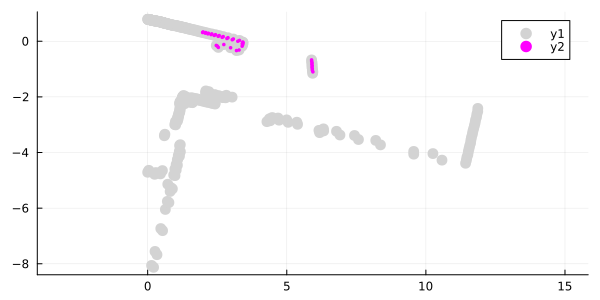

In [89]:
t = 1_100
i = 1

ps  = [Pose(0,0,0)]
ps_ = CuArray(stack(Vector.(ps)))

ys_ = CuArray(stack(_ys[t]))

zs_ = cast_cu(ps_, ys_, fov=π, cell_rad=0.01)
as_ = CuArray(_as)
w   = 20
ys_tilde_ = get_ys_tilde_cu(zs_, as_, w)   
ys_tilde  = Array(ys_tilde_)
println(size(ys_tilde))

# ----------------------
plot(size=(600,300), aspect_ratio=:equal)
scatter!(ys_tilde[1,:,1,1],ys_tilde[1,:,1,2], c=:lightgray, markerstrokewidth=0, markersize=6)
scatter!(ys_tilde[1,180,:,1],ys_tilde[1,180,:,2], c=:magenta, markerstrokewidth=0, markersize=2)

(361,)


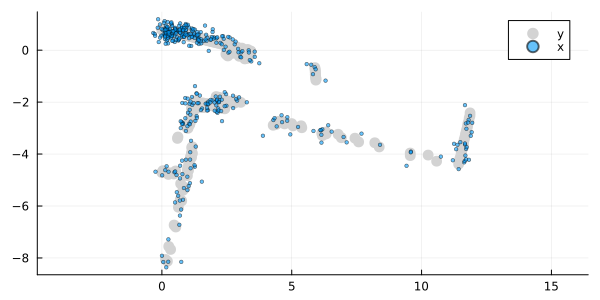

In [93]:
y_tilde_ = ys_tilde_[1,:,:,:]
x = sensordist_cu(y_tilde_, .2, 0.0, 1.0)

println(size(x))
# ----------------------
plot(size=(600,300), aspect_ratio=:equal)
scatter!(ys_tilde[1,:,1,1],ys_tilde[1,:,1,2], c=:lightgray, markerstrokewidth=0, markersize=6, label="y")
scatter!(x, c=col[1], markersize=2, alpha=0.6, label="x")